# Using Convolutional Neural Networks

## Use a pretrained VGG model with our **Vgg16** class

In [1]:
%matplotlib inline

In [2]:
from __future__ import division, print_function
import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=1)
from matplotlib import pyplot as plt
import utils; reload(utils)
from utils import plots
import vgg16; reload(vgg16)
from vgg16 import Vgg16

Using Theano backend.


In [11]:
vgg = Vgg16()
batch_size = 64
path = "sample/"
batches = vgg.get_batches(path + 'train', batch_size = batch_size)
val_batches = vgg.get_batches(path + 'valid', batch_size = (batch_size * 2))
vgg.finetune(batches)
vgg.fit(batches, val_batches, nb_epoch=1)

Found 178 images belonging to 2 classes.
Found 44 images belonging to 2 classes.
Epoch 1/1
178/178 [==============================] - 58s - loss: 1.5133 - acc: 0.5843 - val_loss: 0.4419 - val_acc: 0.7955


In [1]:
imgs,labels=next(batches)
vgg.predict(imgs, True)

# Questions
What is the difference between "train" vs "valid"

## Use Vgg16 for basic image recognition

In [5]:
vgg = Vgg16()
batches = vgg.get_batches('train', batch_size = 64)

Found 22556 images belonging to 2 classes.


In [6]:
imgs,labels = next(batches)

In [7]:
vgg.predict(imgs, True)

(array([ 0.4279,  0.0744,  0.1832,  0.3815,  0.0716,  0.2964,  0.648 ,  0.6494,  0.4938,  0.8975,
         0.9032,  0.9578,  0.2214,  0.88  ,  0.4087,  0.9991,  0.3553,  0.4341,  0.6131,  0.398 ,
         0.5859,  0.1763,  0.2802,  0.501 ,  0.4697,  0.9471,  0.6711,  0.6437,  0.5019,  0.9119,
         0.3339,  0.5245,  0.2643,  0.4794,  0.3932,  0.5713,  0.34  ,  0.7283,  0.85  ,  0.4596,
         0.1864,  0.4069,  0.393 ,  0.4164,  0.3616,  0.0738,  0.2776,  0.5905,  0.6452,  0.3351,
         0.2917,  0.231 ,  0.402 ,  0.4672,  0.6548,  0.3586,  0.664 ,  0.4099,  0.6457,  0.097 ,
         0.7911,  0.2943,  0.3489,  0.2254], dtype=float32),
 array([332, 648, 359, 282, 162, 852, 178, 333, 265, 285, 208, 175, 177, 168, 285, 284, 162, 162,
        161, 284, 187, 165, 285, 281, 164, 257, 156, 281, 210, 254, 285, 281, 728, 285, 168, 222,
        285, 176, 282, 209, 252, 281, 248, 669, 266, 285, 235, 223, 281, 270, 168, 284, 285, 285,
        180, 359, 257, 283, 243, 285, 162, 850, 282, 281]

## Use our Vgg16 class to finetune a Dogs vs Cats model

In [9]:
batches = vgg.get_batches(path + 'train', batch_size = batch_size)
val_batches = vgg.get_batches(path + 'valid', batch_size = batch_size)

Found 178 images belonging to 2 classes.
Found 44 images belonging to 2 classes.


In [10]:
vgg.finetune(batches)
vgg.fit(batches, val_batches, nb_epoch=4)

Epoch 1/4
178/178 [==============================] - 58s - loss: 1.2652 - acc: 0.5843 - val_loss: 0.3412 - val_acc: 0.8409
Epoch 2/4
178/178 [==============================] - 57s - loss: 0.3816 - acc: 0.8820 - val_loss: 0.2016 - val_acc: 0.9091
Epoch 3/4
178/178 [==============================] - 58s - loss: 0.3081 - acc: 0.8764 - val_loss: 0.0614 - val_acc: 0.9773
Epoch 4/4
178/178 [==============================] - 57s - loss: 0.1454 - acc: 0.9494 - val_loss: 0.0232 - val_acc: 1.0000


# Questions

*finetune* - Modifies data such that it will be trained based on data in batches provided (dog, cat)

* So instead of categorizing based on specific category, it groups it by a larger category "dogs" and "cats". Does this mean the original model already has a concept of dogs and cats? It would seem like it has to, otherwise it would be hard to map

    `German Shepherd -> Dog`

    Otherwise the original training data would be useless.

* so finetune really __adjusts the specificity of a given category__?
* How does it get more accurate after running *fit* multiple times over the *same* data?? What is new?
* What is the difference between *finetune* and *fit*

# Create a VGG model from scratch in Keras

In [22]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

In [23]:
FILES_PATH = 'http://www.platform.ai/models/'; CLASS_FILE='imagenet_class_index.json'
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')
with open(fpath) as f: class_dict = json.load(f)

classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [41]:
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))
def vgg_preprocess(x):
    x = x - vgg_mean
    return x[:, ::-1]

def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    
def ConvBlock(layers, model, filters):
    for i in range(layers):
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    #Adding different layers?
    #What this stuff doing?
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))
    
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)
    
    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    #Calling this twice?
    model.add(Dense(1000, activation='softmax'))
    return model

model = VGG_16()

fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)

Found 160 images belonging to 2 classes.


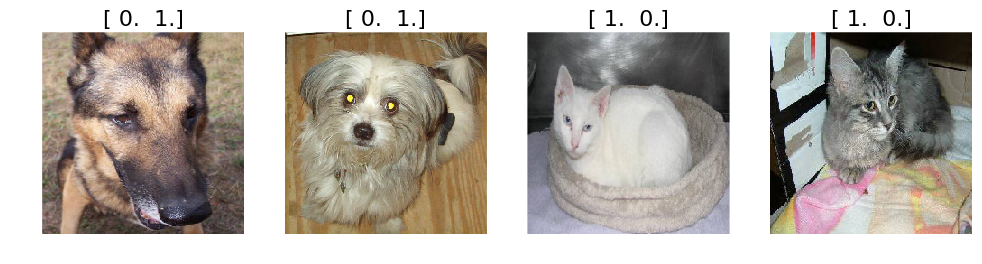

In [43]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, batch_size=4, class_mode='categorical'):
    return gen.flow_from_directory(path+dirname,target_size=(224, 224), class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

batches = get_batches('train', batch_size = 4)
imgs,labels = next(batches)
plots(imgs, titles=labels)

In [44]:
def pred_batch(imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis = 1)
    print('Shape: {}'.format(preds.shape))
    print('First 5 classes: {}'.format(classes[:5]))
    print('First 5 probabilities: {}\n'.format(preds[0, :5]))
    print('Predictions prob/class: ')
    for i in range(len(idxs)):
        idx = idxs[i]
        print('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))
        
        
pred_batch(imgs)

        

Shape: (4, 1000)
First 5 classes: [u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']
First 5 probabilities: [  1.2762e-08   2.3712e-10   3.3695e-09   2.4646e-09   9.4356e-10]

Predictions prob/class: 
  0.6345/German_shepherd
  0.5614/Lhasa
  0.2383/bath_towel
  0.2707/tabby


# Comments

* The model architecture is created by a series of "blocks" to a "Sequential" model
* The model is then trained on a set of data, resulting in a calculation of a set of __weights__
* By making the weights available, we can just download the weights file and use the trained model without retraining it
* __trained model__ = weights + architecture ??